**<h1>📌 Genre-Driven Mood Analysis for Track Classification</h1>**

✅ *In this section, we address the task of categorizing tracks by genre using supervised learning (classification). We begin by acquiring the necessary data from our database and then explore a subset of columns for features, checking for null data and outliers to guide data cleaning. Next, we split the data into training and test sets and apply OrdinalEncoder for non-numeric to numeric conversion and StandardScaler for normalization. Feature selection is based on `RandomForestClassifier.feature_importances_`, with the top 7 columns chosen. A heatmap visualizes feature correlations. Our classification model of choice is Random Forest, and we evaluate its accuracy using the `accuracy_score` metric to measure its genre prediction performance.*

**Importing Libraries** 📚

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import mysql.connector
from scipy.stats import zscore
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

**Connecting to the Database** 📂

In [2]:
my_database = mysql.connector.connect(
  host = "127.0.0.1",
  port = "3306",
  user = "root",
  password = "Your Password",
  auth_plugin = "mysql_native_password",
  database = "spotify"
)

cursor = my_database.cursor()

**Reading data** 📡

In [3]:
cursor.execute("SELECT * FROM track_info")
track_info = cursor.fetchall()
track_info = pd.DataFrame(track_info, columns = [column[0] for column in cursor.description])

cursor.execute("SELECT * FROM genre")
genre = cursor.fetchall()
genre = pd.DataFrame(genre, columns = [column[0] for column in cursor.description])

cursor.execute("SELECT * FROM track_lyric")
track_lyric = cursor.fetchall()
track_lyric = pd.DataFrame(track_lyric, columns = [column[0] for column in cursor.description])

cursor.execute("SELECT * FROM track_music")
track_music = cursor.fetchall()
track_music = pd.DataFrame(track_music, columns = [column[0] for column in cursor.description])

cursor.execute("SELECT * FROM artist")
artist = cursor.fetchall()
artist = pd.DataFrame(artist, columns = [column[0] for column in cursor.description])

track_genre_lyric = pd.merge(track_info, genre, how = "inner", on = "genre_id")
track_genre_lyric = pd.merge(track_genre_lyric, artist, how = "inner", on = "artist_id")
track_genre_lyric = pd.merge(track_genre_lyric, track_lyric, how = "inner", on = "track_id")
track_genre_lyric = pd.merge(track_genre_lyric, track_music, how = "inner", on = "track_id")

pd.set_option("display.max_columns", None)
track_genre_lyric.head()

,track_id,artist_id,genre_id,subgenre_id,album_id,popularity_x,title,explicit,track_asc,genres_name,artist_name,popularity_y,followers,n_words,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,danceability,energy,speechiness,acoustics,instrumentalness,liveliness,valence
0,000xQL6tZNLJzIrtIgxqSl,5ZsFI1h6hIdQRw2ti0hz81,2,2,2kGUeTGnkLOYlinKRJe47G,10214.70,still got time,0,s,pop,ZAYN,75,22636925,446,-1,-1,-1,1,-1.65,-4,-4,1,3,4,4,3,3,2,4,3,5,6,0.006726,0.008969,0.008969,0.006726,0.006726,0.004484,0.008969,0.006726,0.011211,0.013453,0.115385,0.153846,0.153846,0.115385,0.115385,0.076923,0.153846,0.115385,0.454545,0.545455,9,0,-1,1,0,0,0,0,7,1.0,-6.029,120.963,188491,4.0,0.748,0.627,0.0639,0.1310,0.000000,0.0852,0.5240
1,0aVsVsOYDSEEigiwTrIab9,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,1913.60,let me,0,a,pop,ZAYN,75,22636925,234,1,1,1,1,5.60,7,14,6,1,3,1,1,6,1,1,5,2,8,0.004274,0.012821,0.004274,0.004274,0.025641,0.004274,0.004274,0.021368,0.008547,0.034188,0.052632,0.157895,0.052632,0.052632,0.315789,0.052632,0.052632,0.263158,0.200000,0.800000,0,6,-1,1,0,0,0,1,9,1.0,-5.637,168.408,185373,4.0,0.460,0.566,0.0502,0.2390,0.000006,0.0967,0.1890
2,0PDUDa38GO8lMxLCRc4lL1,5ZsFI1h6hIdQRw2ti0hz81,2,2,5amj9zNeZ3B2EdpBgXrOZ0,1805.60,pillowtalk,1,a,pop,ZAYN,75,22636925,289,-1,-1,-1,-1,-2.75,-3,-8,-5,4,0,3,5,1,2,1,0,7,2,0.013841,0.000000,0.010381,0.017301,0.003460,0.006920,0.003460,0.000000,0.024221,0.006920,0.250000,0.000000,0.187500,0.312500,0.062500,0.125000,0.062500,0.000000,0.777778,0.222222,1,6,-1,1,0,0,0,0,11,1.0,-4.275,124.944,202747,4.0,0.584,0.700,0.0456,0.1170,0.000000,0.0939,0.4380
3,155EsNGoXo7XSVF84oTPam,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,58.40,there you are,0,a,pop,ZAYN,75,22636925,222,-1,-1,-1,0,-1.25,-3,-3,0,0,0,1,0,0,0,0,0,1,1,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.004504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0,1,-1,1,0,0,0,0,0,0.0,-4.840,76.990,199600,4.0,0.452,0.688,0.0385,0.0263,0.000000,0.1100,0.3130
4,1dLXLETYiZohIZWnse4ypG,5ZsFI1h6hIdQRw2ti0hz81,2,2,7MkNlHw0O8KKr3yJ3RtgVW,1520.85,better,0,s,pop,ZAYN,75,22636925,206,1,1,1,1,2.85,4,8,4,0,2,0,0,3,0,1,2,0,4,0.000000,0.009709,0.000000,0.000000,0.014563,0.000000,0.004854,0.009709,0.000000,0.019418,0.000000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,0.250000,0.000000,1.000000,0,8,-1,1,0,0,0,1,2,1.0,-7.137,84.295,174517,4.0,0.637,0.418,0.3010,0.3530,0.000000,0.1310,0.0807


In [4]:
cols = ["artist_id", "genre_id", "subgenre_id", "syuzhet_norm",
       "bing_norm", "afinn_norm", "nrc_norm", "syuzhet", "bing", "afinn",
       "nrc", "anger", "anticipation", "disgust", "fear", "joy", "sadness",
       "surprise", "trust", "negative", "positive", "anger_norm",
       "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm",
       "sadness_norm", "surprise_norm", "trust_norm", "negative_norm",
       "positive_norm", "anger_norm2", "anticipation_norm2", "disgust_norm2",
       "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2",
       "trust_norm2", "negative_norm2", "positive_norm2", "negative_bog_jr",
       "positive_bog_jr", "Bayes", "Negative_Bayes", "Neutral_Bayes",
       "Positive_Bayes", "bing_norm_neutral", "bing_norm_positive", "key",
       "mode", "loudness", "tempo", "duration_ms", "time_signature",
       "danceability", "energy", "speechiness", "acoustics",
       "instrumentalness", "liveliness", "valence"]

track_genre_lyric_copy1 = track_genre_lyric[cols].copy()
track_genre_lyric_copy1.head()

,artist_id,genre_id,subgenre_id,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,danceability,energy,speechiness,acoustics,instrumentalness,liveliness,valence
0,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,1,-1.65,-4,-4,1,3,4,4,3,3,2,4,3,5,6,0.006726,0.008969,0.008969,0.006726,0.006726,0.004484,0.008969,0.006726,0.011211,0.013453,0.115385,0.153846,0.153846,0.115385,0.115385,0.076923,0.153846,0.115385,0.454545,0.545455,9,0,-1,1,0,0,0,0,7,1.0,-6.029,120.963,188491,4.0,0.748,0.627,0.0639,0.1310,0.000000,0.0852,0.5240
1,5ZsFI1h6hIdQRw2ti0hz81,2,2,1,1,1,1,5.60,7,14,6,1,3,1,1,6,1,1,5,2,8,0.004274,0.012821,0.004274,0.004274,0.025641,0.004274,0.004274,0.021368,0.008547,0.034188,0.052632,0.157895,0.052632,0.052632,0.315789,0.052632,0.052632,0.263158,0.200000,0.800000,0,6,-1,1,0,0,0,1,9,1.0,-5.637,168.408,185373,4.0,0.460,0.566,0.0502,0.2390,0.000006,0.0967,0.1890
2,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,-1,-2.75,-3,-8,-5,4,0,3,5,1,2,1,0,7,2,0.013841,0.000000,0.010381,0.017301,0.003460,0.006920,0.003460,0.000000,0.024221,0.006920,0.250000,0.000000,0.187500,0.312500,0.062500,0.125000,0.062500,0.000000,0.777778,0.222222,1,6,-1,1,0,0,0,0,11,1.0,-4.275,124.944,202747,4.0,0.584,0.700,0.0456,0.1170,0.000000,0.0939,0.4380
3,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,0,-1.25,-3,-3,0,0,0,1,0,0,0,0,0,1,1,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.004504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0,1,-1,1,0,0,0,0,0,0.0,-4.840,76.990,199600,4.0,0.452,0.688,0.0385,0.0263,0.000000,0.1100,0.3130
4,5ZsFI1h6hIdQRw2ti0hz81,2,2,1,1,1,1,2.85,4,8,4,0,2,0,0,3,0,1,2,0,4,0.000000,0.009709,0.000000,0.000000,0.014563,0.000000,0.004854,0.009709,0.000000,0.019418,0.000000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,0.250000,0.000000,1.000000,0,8,-1,1,0,0,0,1,2,1.0,-7.137,84.295,174517,4.0,0.637,0.418,0.3010,0.3530,0.000000,0.1310,0.0807


In [5]:
track_genre_lyric_copy1.isna().sum()

artist_id           0
genre_id            0
subgenre_id         0
syuzhet_norm        0
bing_norm           0
                   ..
speechiness         0
acoustics           0
instrumentalness    0
liveliness          0
valence             0
Length: 62, dtype: int64

**Comparison of Audio Features and Duration Distribution** 🔊

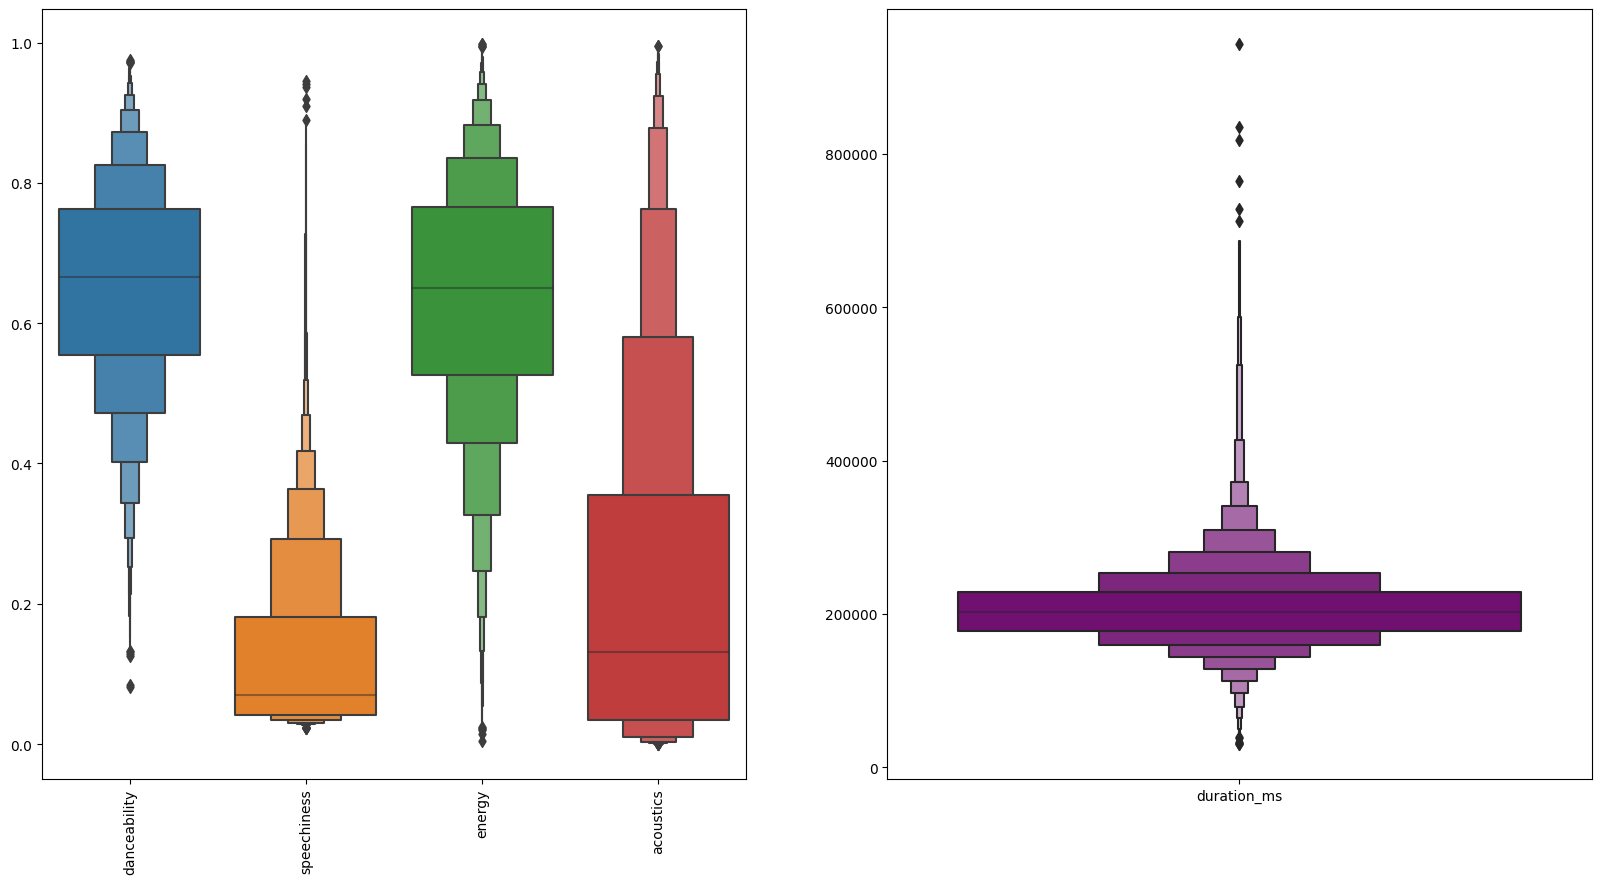

In [6]:
cols = ["danceability", "speechiness", "energy", "acoustics"]

fig, axes = plt.subplots(ncols = 2, figsize = (20, 10))
sns.boxenplot(track_genre_lyric_copy1[cols], ax = axes[0])
sns.boxenplot(track_genre_lyric_copy1[["duration_ms"]], ax = axes[1], color = "purple")
axes[0].set_xticklabels(labels = axes[0].get_xticklabels(), rotation = 90)
plt.show()

In [7]:
for col in ["danceability", "speechiness", "energy", "acoustics", "duration_ms"]:
    z = zscore(track_genre_lyric_copy1[col])
    outliers = abs(z) > 3
    num_outliers = outliers.sum()
    print(f"Number of rows with outlier values in {col}: {num_outliers}")

Number of rows with outlier values in danceability: 35
Number of rows with outlier values in speechiness: 121
Number of rows with outlier values in energy: 54
Number of rows with outlier values in acoustics: 16
Number of rows with outlier values in duration_ms: 134


**Data Cleaning, Outlier Removal, and Handling Missing Values**  💢

In [8]:
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df = df[(df[column] > lower_bound) & (df[column] < upper_bound)]
    return df


for col in ["danceability", "speechiness", "energy", "acoustics", "duration_ms"]:
    track_genre_lyric_copy1 = remove_outliers(track_genre_lyric_copy1, col)

In [9]:
null_rows = track_genre_lyric_copy1[track_genre_lyric_copy1.isnull().any(axis = 1)]
len(null_rows)

70

In [10]:
track_genre_lyric_copy1.dropna(inplace = True)

**Random Forest Classification for Music Genre Prediction** 🧩

In [11]:
y = track_genre_lyric_copy1["genre_id"]
track_genre_lyric_copy1.drop(columns = ["genre_id"], inplace = True)
x_train, x_test, y_train, y_test = train_test_split(track_genre_lyric_copy1, y, test_size = 0.2, random_state = 31)

In [12]:
categorical_cols = x_train.select_dtypes(include = ["object", "float"]).columns
enc = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)
x_train[categorical_cols] = enc.fit_transform(x_train[categorical_cols])
x_test[categorical_cols] = enc.transform(x_test[categorical_cols])

In [13]:
num_cols = x_train.select_dtypes(include = np.number).columns

std_scaler = StandardScaler()
x_train.loc[:, num_cols] = std_scaler.fit_transform(x_train.loc[:, num_cols])
x_test.loc[:, num_cols] = std_scaler.transform(x_test.loc[:, num_cols])

x_train.head()

,artist_id,subgenre_id,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,danceability,energy,speechiness,acoustics,instrumentalness,liveliness,valence
11341,-1.373459,-0.441355,0.945159,1.289037,1.110562,1.053363,0.565793,0.532734,0.719203,0.519005,-0.638501,-0.475773,-0.442282,-0.697509,-0.094943,0.094780,-1.142774,-1.160860,-0.549009,-0.125155,-0.531515,0.174558,-0.084464,-0.645982,0.965678,1.240442,-1.271696,-1.415953,-0.100557,1.096898,-0.544086,0.681807,0.213517,-0.661909,1.160671,1.538374,-1.385182,-1.525994,-0.802269,0.802269,-0.273316,-0.293061,1.235676,-1.121601,-0.257702,1.275716,-0.369580,1.370980,1.313236,0.856540,-0.849892,-1.310552,0.161810,0.078047,-1.287947,-0.156232,-1.038230,0.682657,-0.455098,-0.080214,-1.176433
9776,-1.358229,0.338552,0.945159,1.289037,1.110562,1.053363,0.908642,1.041009,0.349260,0.519005,-0.996747,-0.069655,-0.923646,-0.697509,-0.094943,-1.161548,-0.545488,-0.450450,-0.768196,-0.370230,-1.199174,0.011698,-1.078209,-1.017674,0.000627,-1.385898,-0.741308,-0.611447,-1.136844,-0.509642,-1.196846,1.471059,-1.102466,-0.538543,1.277308,-1.420864,0.412325,0.933323,-0.949571,0.949571,-0.440853,-0.168720,-0.864865,0.891582,-0.257702,-0.783874,-0.369580,1.370980,-0.066613,-1.167488,0.218585,-0.046992,0.672542,0.078047,0.118055,-0.520006,0.017980,0.427789,-0.455098,-0.259256,-1.715986
9573,0.898571,0.583978,-0.060285,0.201499,1.110562,-1.087800,0.010705,0.278596,0.349260,-0.261813,-0.638501,-0.069655,-0.923646,-1.051294,-0.515634,-0.323996,-0.545488,-0.450450,-0.549009,-0.860380,-0.855494,0.145697,-1.078209,-1.290668,-0.558523,-0.277574,-0.678166,-0.530372,-0.732182,-1.200172,-0.544086,1.386872,-1.102466,-1.319857,0.587204,0.946527,0.205855,0.675952,0.714942,-0.714942,-0.273316,-0.293061,-0.864865,0.891582,-0.257702,-0.783874,2.705771,-0.729405,1.589206,-1.167488,1.233398,-0.701184,0.250467,0.078047,-1.022528,0.796196,-1.062793,0.248438,-0.455098,0.830793,-0.074269
2294,-0.826565,1.156637,0.945159,1.289037,1.110562,1.053363,0.908642,1.041009,0.349260,0.519005,-0.996747,-0.069655,-0.923646,-0.697509,-0.094943,-1.161548,-0.545488,-0.450450,-0.768196,-0.370230,-1.199174,0.011698,-1.078209,-1.017674,0.000627,-1.385898,-0.741308,-0.611447,-1.136844,-0.509642,-1.196846,1.471059,-1.102466,-0.538543,1.277308,-1.420864,0.412325,0.933323,-0.949571,0.949571,-0.440853,-0.168720,-0.864865,0.891582,-0.257702,-0.783874,-0.369580,1.370980,0.485326,0.856540,-1.626820,-1.449561,0.367312,0.078047,-0.893406,0.081875,-1.090426,0.888439,-0.173361,0.030371,-1.499243
10093,-1.359613,0.338552,0.945159,1.289037,1.110562,1.053363,0.337228,1.041009,0.904174,0.779277,-0.280255,1.554820,-0.442282,1.071414,1.587825,-0.323996,2.440940,0.615164,-0.110637,0.610070,-0.754798,0.793013,-0.997703,0.590889,0.739947,-0.870549,1.347410,0.049621,-0.760332,-0.100961,-0.929808,0.850180,-0.967178,0.633427,0.703841,-1.099862,1.371805,-0.105691,-0.758078,0.758078,-0.440853,0.826004,-0.864865,0.891582,-0.257702,-0.783874,-0.369580,1.370980,-1.170493,0.856540,1.606645,-0.544586,-0.517444,0.078047,0.670413,1.100444,1.307539,0.452332,-0.455098,-0.027555,2.166951


In [14]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
importance = rf.feature_importances_
features = pd.DataFrame({"feature": x_train.columns, "importance": importance})
features = features.sort_values(by = "importance", ascending = False)

print(features)

               feature  importance
1          subgenre_id    0.125312
56         speechiness    0.051064
54        danceability    0.037864
52         duration_ms    0.028911
0            artist_id    0.028142
..                 ...         ...
2         syuzhet_norm    0.002572
47  bing_norm_positive    0.002477
46   bing_norm_neutral    0.002323
53      time_signature    0.001978
44       Neutral_Bayes    0.001569

[61 rows x 2 columns]


In [15]:
cols = ["subgenre_id", "danceability", "speechiness", "duration_ms", "artist_id", "energy", "acoustics"]

<AxesSubplot: >

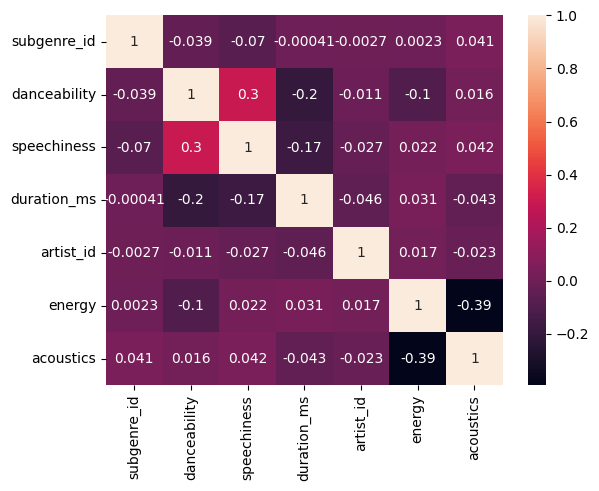

In [16]:
sns.heatmap(x_train[cols].corr(), annot = True)

In [17]:
x_train = x_train[cols]
x_test = x_test[cols]
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state = 0)
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [18]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.5920781893004116


**Music Mood Classification and Feature Selection** 🎶

In [19]:
track_genre_lyric_copy2 = track_genre_lyric.copy()
track_genre_lyric_copy2.head()

,track_id,artist_id,genre_id,subgenre_id,album_id,popularity_x,title,explicit,track_asc,genres_name,artist_name,popularity_y,followers,n_words,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,danceability,energy,speechiness,acoustics,instrumentalness,liveliness,valence
0,000xQL6tZNLJzIrtIgxqSl,5ZsFI1h6hIdQRw2ti0hz81,2,2,2kGUeTGnkLOYlinKRJe47G,10214.70,still got time,0,s,pop,ZAYN,75,22636925,446,-1,-1,-1,1,-1.65,-4,-4,1,3,4,4,3,3,2,4,3,5,6,0.006726,0.008969,0.008969,0.006726,0.006726,0.004484,0.008969,0.006726,0.011211,0.013453,0.115385,0.153846,0.153846,0.115385,0.115385,0.076923,0.153846,0.115385,0.454545,0.545455,9,0,-1,1,0,0,0,0,7,1.0,-6.029,120.963,188491,4.0,0.748,0.627,0.0639,0.1310,0.000000,0.0852,0.5240
1,0aVsVsOYDSEEigiwTrIab9,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,1913.60,let me,0,a,pop,ZAYN,75,22636925,234,1,1,1,1,5.60,7,14,6,1,3,1,1,6,1,1,5,2,8,0.004274,0.012821,0.004274,0.004274,0.025641,0.004274,0.004274,0.021368,0.008547,0.034188,0.052632,0.157895,0.052632,0.052632,0.315789,0.052632,0.052632,0.263158,0.200000,0.800000,0,6,-1,1,0,0,0,1,9,1.0,-5.637,168.408,185373,4.0,0.460,0.566,0.0502,0.2390,0.000006,0.0967,0.1890
2,0PDUDa38GO8lMxLCRc4lL1,5ZsFI1h6hIdQRw2ti0hz81,2,2,5amj9zNeZ3B2EdpBgXrOZ0,1805.60,pillowtalk,1,a,pop,ZAYN,75,22636925,289,-1,-1,-1,-1,-2.75,-3,-8,-5,4,0,3,5,1,2,1,0,7,2,0.013841,0.000000,0.010381,0.017301,0.003460,0.006920,0.003460,0.000000,0.024221,0.006920,0.250000,0.000000,0.187500,0.312500,0.062500,0.125000,0.062500,0.000000,0.777778,0.222222,1,6,-1,1,0,0,0,0,11,1.0,-4.275,124.944,202747,4.0,0.584,0.700,0.0456,0.1170,0.000000,0.0939,0.4380
3,155EsNGoXo7XSVF84oTPam,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,58.40,there you are,0,a,pop,ZAYN,75,22636925,222,-1,-1,-1,0,-1.25,-3,-3,0,0,0,1,0,0,0,0,0,1,1,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.004504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0,1,-1,1,0,0,0,0,0,0.0,-4.840,76.990,199600,4.0,0.452,0.688,0.0385,0.0263,0.000000,0.1100,0.3130
4,1dLXLETYiZohIZWnse4ypG,5ZsFI1h6hIdQRw2ti0hz81,2,2,7MkNlHw0O8KKr3yJ3RtgVW,1520.85,better,0,s,pop,ZAYN,75,22636925,206,1,1,1,1,2.85,4,8,4,0,2,0,0,3,0,1,2,0,4,0.000000,0.009709,0.000000,0.000000,0.014563,0.000000,0.004854,0.009709,0.000000,0.019418,0.000000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,0.250000,0.000000,1.000000,0,8,-1,1,0,0,0,1,2,1.0,-7.137,84.295,174517,4.0,0.637,0.418,0.3010,0.3530,0.000000,0.1310,0.0807


In [20]:
moods = {
    "sad": ["sadness"],
    "happy": ["joy"],
    "relaxing": ["trust"],
    "energetic": ["energy"],
    "angry": ["anger"],
    "dancing": ["danceability"]
}

mood_range = {
    "sadness": (min(track_genre_lyric_copy2["sadness"]) + max(track_genre_lyric_copy2["sadness"])) / 2,
    "joy": (min(track_genre_lyric_copy2["joy"]) + max(track_genre_lyric_copy2["joy"])) / 2,
    "trust": (min(track_genre_lyric_copy2["trust"]) + max(track_genre_lyric_copy2["trust"])) / 2,
    "positive": (min(track_genre_lyric_copy2["positive"]) + max(track_genre_lyric_copy2["positive"])) / 2,
    "energy": (min(track_genre_lyric_copy2["energy"]) + max(track_genre_lyric_copy2["energy"])) / 2,
    "anger": (min(track_genre_lyric_copy2["anger"]) + max(track_genre_lyric_copy2["anger"])) / 2,
    "danceability": (min(track_genre_lyric_copy2["danceability"]) + max(track_genre_lyric_copy2["danceability"])) / 2
}


def assign_mood(row):
    for mood, conditions in moods.items():
        if all(row[condition] > mood_range[condition] for condition in conditions):
            return mood
    return None

track_genre_lyric_copy2 = track_genre_lyric_copy2.assign(my_mood = track_genre_lyric_copy2.apply(assign_mood, axis = 1))
pd.set_option("display.max_columns", None)
track_genre_lyric_copy2.head()

,track_id,artist_id,genre_id,subgenre_id,album_id,popularity_x,title,explicit,track_asc,genres_name,artist_name,popularity_y,followers,n_words,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anger,anticipation,disgust,fear,joy,sadness,surprise,trust,negative,positive,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,danceability,energy,speechiness,acoustics,instrumentalness,liveliness,valence,my_mood
0,000xQL6tZNLJzIrtIgxqSl,5ZsFI1h6hIdQRw2ti0hz81,2,2,2kGUeTGnkLOYlinKRJe47G,10214.70,still got time,0,s,pop,ZAYN,75,22636925,446,-1,-1,-1,1,-1.65,-4,-4,1,3,4,4,3,3,2,4,3,5,6,0.006726,0.008969,0.008969,0.006726,0.006726,0.004484,0.008969,0.006726,0.011211,0.013453,0.115385,0.153846,0.153846,0.115385,0.115385,0.076923,0.153846,0.115385,0.454545,0.545455,9,0,-1,1,0,0,0,0,7,1.0,-6.029,120.963,188491,4.0,0.748,0.627,0.0639,0.1310,0.000000,0.0852,0.5240,energetic
1,0aVsVsOYDSEEigiwTrIab9,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,1913.60,let me,0,a,pop,ZAYN,75,22636925,234,1,1,1,1,5.60,7,14,6,1,3,1,1,6,1,1,5,2,8,0.004274,0.012821,0.004274,0.004274,0.025641,0.004274,0.004274,0.021368,0.008547,0.034188,0.052632,0.157895,0.052632,0.052632,0.315789,0.052632,0.052632,0.263158,0.200000,0.800000,0,6,-1,1,0,0,0,1,9,1.0,-5.637,168.408,185373,4.0,0.460,0.566,0.0502,0.2390,0.000006,0.0967,0.1890,energetic
2,0PDUDa38GO8lMxLCRc4lL1,5ZsFI1h6hIdQRw2ti0hz81,2,2,5amj9zNeZ3B2EdpBgXrOZ0,1805.60,pillowtalk,1,a,pop,ZAYN,75,22636925,289,-1,-1,-1,-1,-2.75,-3,-8,-5,4,0,3,5,1,2,1,0,7,2,0.013841,0.000000,0.010381,0.017301,0.003460,0.006920,0.003460,0.000000,0.024221,0.006920,0.250000,0.000000,0.187500,0.312500,0.062500,0.125000,0.062500,0.000000,0.777778,0.222222,1,6,-1,1,0,0,0,0,11,1.0,-4.275,124.944,202747,4.0,0.584,0.700,0.0456,0.1170,0.000000,0.0939,0.4380,energetic
3,155EsNGoXo7XSVF84oTPam,5ZsFI1h6hIdQRw2ti0hz81,2,2,37PlDQrSCWOiQlrA1AvUqx,58.40,there you are,0,a,pop,ZAYN,75,22636925,222,-1,-1,-1,0,-1.25,-3,-3,0,0,0,1,0,0,0,0,0,1,1,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.004504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0,1,-1,1,0,0,0,0,0,0.0,-4.840,76.990,199600,4.0,0.452,0.688,0.0385,0.0263,0.000000,0.1100,0.3130,energetic
4,1dLXLETYiZohIZWnse4ypG,5ZsFI1h6hIdQRw2ti0hz81,2,2,7MkNlHw0O8KKr3yJ3RtgVW,1520.85,better,0,s,pop,ZAYN,75,22636925,206,1,1,1,1,2.85,4,8,4,0,2,0,0,3,0,1,2,0,4,0.000000,0.009709,0.000000,0.000000,0.014563,0.000000,0.004854,0.009709,0.000000,0.019418,0.000000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,0.250000,0.000000,1.000000,0,8,-1,1,0,0,0,1,2,1.0,-7.137,84.295,174517,4.0,0.637,0.418,0.3010,0.3530,0.000000,0.1310,0.0807,dancing


In [21]:
null_rows = track_genre_lyric_copy2[track_genre_lyric_copy2.isnull().any(axis = 1)]
len(null_rows)

838

In [22]:
track_genre_lyric_copy2.dropna(inplace = True)
track_genre_lyric_copy2.my_mood.fillna("happy", inplace = True)

In [23]:
track_genre_lyric_copy2.columns

Index(['track_id', 'artist_id', 'genre_id', 'subgenre_id', 'album_id',
       'popularity_x', 'title', 'explicit', 'track_asc', 'genres_name',
       'artist_name', 'popularity_y', 'followers', 'n_words', 'syuzhet_norm',
       'bing_norm', 'afinn_norm', 'nrc_norm', 'syuzhet', 'bing', 'afinn',
       'nrc', 'anger', 'anticipation', 'disgust', 'fear', 'joy', 'sadness',
       'surprise', 'trust', 'negative', 'positive', 'anger_norm',
       'anticipation_norm', 'disgust_norm', 'fear_norm', 'joy_norm',
       'sadness_norm', 'surprise_norm', 'trust_norm', 'negative_norm',
       'positive_norm', 'anger_norm2', 'anticipation_norm2', 'disgust_norm2',
       'fear_norm2', 'joy_norm2', 'sadness_norm2', 'surprise_norm2',
       'trust_norm2', 'negative_norm2', 'positive_norm2', 'negative_bog_jr',
       'positive_bog_jr', 'Bayes', 'Negative_Bayes', 'Neutral_Bayes',
       'Positive_Bayes', 'bing_norm_neutral', 'bing_norm_positive', 'key',
       'mode', 'loudness', 'tempo', 'duration_ms', 'ti

In [24]:
cols = ["artist_id", "genre_id", "subgenre_id", "syuzhet_norm",
        "bing_norm", "afinn_norm", "nrc_norm", "syuzhet", "bing", "afinn",
        "nrc", "anticipation", "disgust", "fear", "surprise", "negative", "anger_norm",
        "anticipation_norm", "disgust_norm", "fear_norm", "joy_norm",
        "sadness_norm", "surprise_norm", "trust_norm", "negative_norm",
        "positive_norm", "anger_norm2", "anticipation_norm2", "disgust_norm2",
        "fear_norm2", "joy_norm2", "sadness_norm2", "surprise_norm2",
        "trust_norm2", "negative_norm2", "positive_norm2", "negative_bog_jr",
        "positive_bog_jr", "Bayes", "Negative_Bayes", "Neutral_Bayes",
        "Positive_Bayes", "bing_norm_neutral", "bing_norm_positive", "key",
        "mode", "loudness", "tempo", "duration_ms", "time_signature", "speechiness",
        "acoustics", "instrumentalness", "liveliness", "valence", "my_mood"]

track_genre_lyric_copy2 = track_genre_lyric_copy2[cols]
track_genre_lyric_copy2.head()

,artist_id,genre_id,subgenre_id,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anticipation,disgust,fear,surprise,negative,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,speechiness,acoustics,instrumentalness,liveliness,valence,my_mood
0,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,1,-1.65,-4,-4,1,4,4,3,4,5,0.006726,0.008969,0.008969,0.006726,0.006726,0.004484,0.008969,0.006726,0.011211,0.013453,0.115385,0.153846,0.153846,0.115385,0.115385,0.076923,0.153846,0.115385,0.454545,0.545455,9,0,-1,1,0,0,0,0,7,1.0,-6.029,120.963,188491,4.0,0.0639,0.1310,0.000000,0.0852,0.5240,energetic
1,5ZsFI1h6hIdQRw2ti0hz81,2,2,1,1,1,1,5.60,7,14,6,3,1,1,1,2,0.004274,0.012821,0.004274,0.004274,0.025641,0.004274,0.004274,0.021368,0.008547,0.034188,0.052632,0.157895,0.052632,0.052632,0.315789,0.052632,0.052632,0.263158,0.200000,0.800000,0,6,-1,1,0,0,0,1,9,1.0,-5.637,168.408,185373,4.0,0.0502,0.2390,0.000006,0.0967,0.1890,energetic
2,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,-1,-2.75,-3,-8,-5,0,3,5,1,7,0.013841,0.000000,0.010381,0.017301,0.003460,0.006920,0.003460,0.000000,0.024221,0.006920,0.250000,0.000000,0.187500,0.312500,0.062500,0.125000,0.062500,0.000000,0.777778,0.222222,1,6,-1,1,0,0,0,0,11,1.0,-4.275,124.944,202747,4.0,0.0456,0.1170,0.000000,0.0939,0.4380,energetic
3,5ZsFI1h6hIdQRw2ti0hz81,2,2,-1,-1,-1,0,-1.25,-3,-3,0,0,1,0,0,1,0.000000,0.000000,0.004504,0.000000,0.000000,0.000000,0.000000,0.000000,0.004504,0.004504,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,0.500000,0,1,-1,1,0,0,0,0,0,0.0,-4.840,76.990,199600,4.0,0.0385,0.0263,0.000000,0.1100,0.3130,energetic
4,5ZsFI1h6hIdQRw2ti0hz81,2,2,1,1,1,1,2.85,4,8,4,2,0,0,1,0,0.000000,0.009709,0.000000,0.000000,0.014563,0.000000,0.004854,0.009709,0.000000,0.019418,0.000000,0.250000,0.000000,0.000000,0.375000,0.000000,0.125000,0.250000,0.000000,1.000000,0,8,-1,1,0,0,0,1,2,1.0,-7.137,84.295,174517,4.0,0.3010,0.3530,0.000000,0.1310,0.0807,dancing


**Random Forest Classification for Music Mood Prediction** 📦

In [25]:
y = track_genre_lyric_copy2["my_mood"]
track_genre_lyric_copy2.drop(columns = ["my_mood"], inplace = True)
x_train, x_test, y_train, y_test = train_test_split(track_genre_lyric_copy2, y, test_size = 0.2, random_state = 31)

In [26]:
categorical_cols = x_train.select_dtypes(include = ["object", "float"]).columns

enc = OrdinalEncoder(handle_unknown = "use_encoded_value", unknown_value = -1)

x_train[categorical_cols] = enc.fit_transform(x_train[categorical_cols])
x_test[categorical_cols] = enc.transform(x_test[categorical_cols])

In [27]:
num_cols = x_train.select_dtypes(include = np.number).columns

std_scaler = StandardScaler()
x_train.loc[:, num_cols] = std_scaler.fit_transform(x_train.loc[:, num_cols])
x_test.loc[:, num_cols] = std_scaler.transform(x_test.loc[:, num_cols])

x_train.head()

,artist_id,genre_id,subgenre_id,syuzhet_norm,bing_norm,afinn_norm,nrc_norm,syuzhet,bing,afinn,nrc,anticipation,disgust,fear,surprise,negative,anger_norm,anticipation_norm,disgust_norm,fear_norm,joy_norm,sadness_norm,surprise_norm,trust_norm,negative_norm,positive_norm,anger_norm2,anticipation_norm2,disgust_norm2,fear_norm2,joy_norm2,sadness_norm2,surprise_norm2,trust_norm2,negative_norm2,positive_norm2,negative_bog_jr,positive_bog_jr,Bayes,Negative_Bayes,Neutral_Bayes,Positive_Bayes,bing_norm_neutral,bing_norm_positive,key,mode,loudness,tempo,duration_ms,time_signature,speechiness,acoustics,instrumentalness,liveliness,valence
514,-0.558847,-0.664239,-0.565704,-1.056462,-0.878691,-0.944852,-1.086671,-1.685293,-1.440403,-0.987222,-1.006352,-0.495800,0.920869,-0.370139,-1.135505,0.470761,2.084045,0.602187,2.292718,0.704794,0.543384,0.818535,-1.286999,0.545961,2.007848,1.024282,1.654913,-0.560830,2.064586,-0.415777,-0.511575,-0.237222,-1.374902,-0.609995,1.148411,-1.148411,-0.122981,-0.679274,-0.875127,0.905354,-0.274521,-0.783493,-0.350425,-0.736541,1.037002,-1.165493,1.525109,0.991519,-0.626612,0.073507,-0.746903,-0.993051,-0.458913,1.063305,2.009634
8368,-1.300790,0.664762,-0.432606,0.952641,-0.878691,1.126686,1.051109,0.504758,0.042874,0.638818,0.513080,-0.495800,-0.460109,-0.035922,0.002080,-0.770092,-0.833194,-0.504878,-0.504896,0.381635,0.842814,0.499961,0.381036,-0.473103,-1.063978,-0.309792,-0.956996,-0.560830,-0.577687,0.657435,0.925540,0.751646,0.622271,-0.609995,-0.966143,0.966143,-0.446956,-0.929722,-0.875127,0.905354,-0.274521,-0.783493,-0.350425,-0.736541,-0.067084,0.858006,0.286909,0.376338,0.181311,0.073507,-1.316012,0.286136,-0.436299,-1.697045,0.008785
1228,0.121601,-0.664239,-0.022222,0.952641,1.283534,1.126686,1.051109,0.790417,1.031726,1.180832,0.259842,-0.495800,-0.920435,-0.704356,0.002080,-0.976901,-0.907736,-0.662752,-1.088605,-1.019377,-1.276376,-1.375189,0.176066,-1.166144,-1.436420,-1.238850,0.014451,1.303014,-1.108353,-0.171010,-0.248688,-1.431328,1.680882,-0.365536,-0.966143,0.966143,-0.608943,0.823409,1.231541,-1.104541,-0.274521,1.276335,-0.350425,1.357697,-1.447191,0.858006,-0.806106,1.575730,0.387257,0.073507,-0.054586,1.222878,-0.458913,-0.659979,-1.104851
4821,0.461157,-0.885739,-0.582341,-1.056462,-0.878691,-0.944852,-1.086671,-0.939406,-1.193190,-0.535544,-1.512830,-0.108232,1.841521,0.966730,0.002080,1.091187,1.316457,-0.877148,1.143905,0.310698,-1.235808,-0.627145,-0.679156,-0.828409,0.312081,-1.037169,1.902357,-1.005062,1.732920,0.808062,-1.422917,-0.619709,-0.643697,-0.926886,1.252192,-1.252192,0.686956,-0.053156,1.231541,-1.104541,-0.274521,1.276335,-0.350425,-0.736541,-1.171170,0.858006,0.912027,1.239795,0.522577,0.073507,0.925220,-0.806428,-0.458913,0.691819,0.286039
3390,-0.379711,-0.664239,-0.266234,0.952641,-0.878691,0.090917,-0.017781,0.266709,0.042874,0.277476,0.006603,-0.108232,-0.460109,-0.704356,-1.135505,-0.356474,-0.126045,0.399485,-0.446758,-0.903119,0.363727,-0.891279,-1.286999,-1.060724,-0.159240,-0.180848,0.848429,1.303014,-0.002799,-0.820586,1.083273,-0.703670,-1.374902,-0.981210,-0.083998,0.083998,1.172918,-0.303604,1.231541,-1.104541,-0.274521,1.276335,-0.350425,-0.736541,-0.619127,0.858006,0.532142,-1.587307,-0.192729,0.073507,-1.418686,-0.806428,0.238889,-0.138866,-0.605794


In [28]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_train = pd.DataFrame(y_train, columns = ["my_mood"])

y_test = encoder.transform(y_test)
y_test = pd.DataFrame(y_test, columns = ["my_mood"])

In [29]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)
importance = rf.feature_importances_
features = pd.DataFrame({"feature": x_train.columns, "importance": importance})
features = features.sort_values(by = "importance", ascending = False)
print(features)

C:\Users\milad\AppData\Local\Temp\ipykernel_13500\4112986936.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(x_train, y_train)


               feature  importance
46            loudness    0.191848
51           acoustics    0.094387
54             valence    0.034916
50         speechiness    0.029966
48         duration_ms    0.027367
47               tempo    0.026027
11        anticipation    0.024114
53          liveliness    0.023070
7              syuzhet    0.021769
15            negative    0.020135
2          subgenre_id    0.019848
0            artist_id    0.018852
23          trust_norm    0.017974
13                fear    0.017037
9                afinn    0.017025
10                 nrc    0.016656
25       positive_norm    0.016514
24       negative_norm    0.016290
20            joy_norm    0.015500
33         trust_norm2    0.015327
31       sadness_norm2    0.015038
17   anticipation_norm    0.014993
27  anticipation_norm2    0.014791
30           joy_norm2    0.014756
21        sadness_norm    0.014732
8                 bing    0.014334
26         anger_norm2    0.014165
16          anger_no

In [30]:
cols = ["loudness", "acoustics", "valence", "speechiness", "duration_ms", "tempo", "syuzhet"]

<AxesSubplot: >

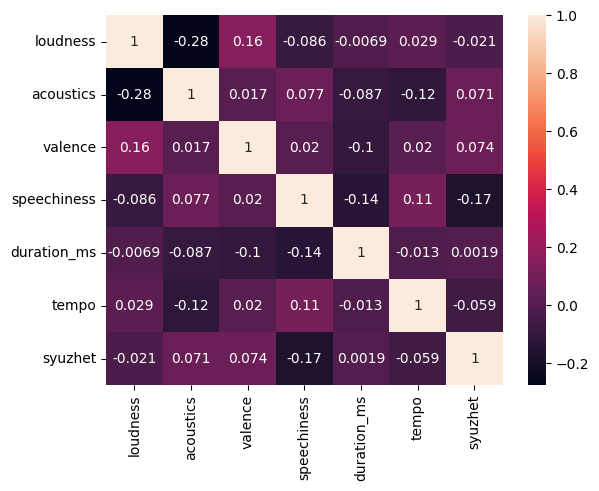

In [31]:
sns.heatmap(x_train[cols].corr(), annot = True)

In [32]:
x_train = x_train[cols]
x_test = x_test[cols]
rf = RandomForestClassifier(n_estimators = 200, max_depth = 10, random_state = 0)
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
rf.fit(x_train, y_train)
y_pred = rf.predict(x_test)

In [33]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.6809815950920245
